In [1]:
import tensorflow as tf
import contractions
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
import time
from konlpy.tag import Mecab
from tqdm import tqdm
tqdm.pandas()

In [2]:
path = '/aiffel/aiffel/goingdeeper/'
df = pd.read_excel(path+"ko_en_data.xlsx")
text_df = df[['원문','번역문']]
text_df.sample()

In [9]:
import contractions
def ko_preprocess(sentence):
    w = sentence.strip()
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    w = re.sub(r"[^가-힣?.!,¿]+", " ", w)
    w = w.strip()
    mecab = Mecab()
    w = mecab.morphs(w)
    w = " ".join(w)
    w = "<start> " + w + ' <end>'
    return w

def en_preprocess(sentence):
    w = contractions.fix(sentence)
    w = sentence.lower().strip()
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = "<start> " + w + ' <end>'
    return w

In [10]:
text_df["ko"] = text_df.원문.progress_apply(ko_preprocess)
text_df['en'] = text_df.번역문.progress_apply(en_preprocess)

100%|██████████| 200011/200011 [04:28<00:00, 743.70it/s]
/tmp/ipykernel_161/2021928097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["ko"] = text_df.원문.progress_apply(ko_preprocess)
100%|██████████| 200011/200011 [00:08<00:00, 23802.88it/s]
/tmp/ipykernel_161/2021928097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['en'] = text_df.번역문.progress_apply(en_preprocess)


In [11]:
text_df.ko

0         <start> 스키너 가 말 한 보상 은 대부분 눈 으로 볼 수 있 는 현물 이 다...
1         <start> 심지어 어떤 문제 가 발생 할 건지 도 어느 정도 예측 이 가능 하 ...
2         <start> 오직 하나님 만 이 그 이유 를 제대로 알 수 있 을 겁니다 . <end>
3         <start> 중국 의 논쟁 을 보 며 간과 해선 안 될 게 기업 들 의 고충 이 ...
4         <start> 박자 가 느린 노래 는 오랜 시간 이 지나 뜨 는 경우 가 있 다 ....
                                ...                        
200006    <start> 당시 에 는 경찰 의 금지 통보 로 청와대 근처 집회 가 불 가능 하...
200007    <start> 양승태 대법원 과 박근혜 청와대 의 대표 적 재판 거래 의혹 사건 으...
200008    <start> 윤석열 서울 중앙지 검장 이 일 국정 감사 에 출석 해 적폐 수사 호...
200009    <start> 대법원 에 재 상고 된 지 년 이 넘 도록 재판 이 지연 되 면서 양...
200010    <start> 양승태 대법원 은 민사 소송 규칙 까지 고쳐 외교부 가 대 법원 에 ...
Name: ko, Length: 200011, dtype: object

In [117]:
def tokenize(sentence):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
    tokenizer.fit_on_texts(sentence)
    tensor = tokenizer.texts_to_sequences(sentence)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, tokenizer

ko_tensor, ko_tokenizer = tokenize(text_df.ko[:50000].to_list())
en_tensor, en_tokenizer = tokenize(text_df.en[:50000].to_list())

In [118]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
convert( ko_tokenizer,ko_tensor[0],)

3 ----> <start>
24750 ----> 스키너
8 ----> 가
61 ----> 말
16 ----> 한
1598 ----> 보상
12 ----> 은
444 ----> 대부분
282 ----> 눈
19 ----> 으로
288 ----> 볼
27 ----> 수
13 ----> 있
6 ----> 는
9410 ----> 현물
1 ----> 이
5 ----> 다
2 ----> .
4 ----> <end>


In [119]:
ko_train, ko_test, en_train, en_test = train_test_split(ko_tensor, en_tensor, test_size=0.2)
print(len(ko_train),len(ko_test),len(en_train),len(en_test))

40000 10000 40000 10000


In [120]:
BUFFER_SIZE = len(ko_train)
BATCH_SIZE = 64
steps_per_epoch = len(ko_train) // BATCH_SIZE
embedding_dim = 256
units=1024
ko_vocab_size = len(ko_tokenizer.word_index)+1
en_vocab_size = len(en_tokenizer.word_index)+1
AUTO = tf.data.AUTOTUNE
dataset = tf.data.Dataset.from_tensor_slices((ko_train, en_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO).prefetch(AUTO)

In [121]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [122]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 61]), TensorShape([64, 46]))

In [123]:
encoder = Encoder(ko_vocab_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 61, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [124]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
        # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
        # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.
        # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
        query_with_time_axis = tf.expand_dims(query, 1)

        # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
        # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
        # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
        score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다. 
        attention_weights = tf.nn.softmax(score, axis=1)

    # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [125]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

In [126]:
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 61, 1)


In [127]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    # 어텐션을 사용합니다.
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        
            # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.
        context_vector, attention_weights = self.attention(hidden, enc_output)

    # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
        x = self.embedding(x)

    # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 위에서 결합된 벡터를 GRU에 전달합니다.
        output, state = self.gru(x)

    # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
        output = tf.reshape(output, (-1, output.shape[2]))

    # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
        x = self.fc(output)

        return x, state, attention_weights

In [128]:
decoder = Decoder(en_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 32388)


In [129]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [130]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [131]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([en_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

      # 교사 강요(teacher forcing)를 사용합니다.
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [132]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    pre_loss = 0
    current_loss = 0
    patience_limit = 4
    patience_count = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
           
        
    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    
        
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    current_loss = batch_loss.numpy()
    if current_loss > pre_loss:
        patience_count += 1
        print("patience_count + 1")
        pre_loss = current_loss
    pre_loss = current_loss
    if patience_count > patience_limit:
        print("Early stopping")
        break

Epoch 1 Loss 3.1206
Time taken for 1 epoch 543.1633012294769 sec

patience_count + 1
Epoch 2 Loss 2.7283
Time taken for 1 epoch 507.9747669696808 sec

patience_count + 1
Epoch 3 Loss 2.4837
Time taken for 1 epoch 504.60764384269714 sec

patience_count + 1
Epoch 4 Loss 2.2815
Time taken for 1 epoch 513.382479429245 sec

patience_count + 1
Epoch 5 Loss 2.0982
Time taken for 1 epoch 505.8356499671936 sec

patience_count + 1
Epoch 6 Loss 1.9177
Time taken for 1 epoch 513.7783784866333 sec

patience_count + 1
Epoch 7 Loss 1.7369
Time taken for 1 epoch 505.9370048046112 sec

patience_count + 1
Epoch 8 Loss 1.5602
Time taken for 1 epoch 513.9078900814056 sec

patience_count + 1
Epoch 9 Loss 1.3933
Time taken for 1 epoch 505.9334077835083 sec

patience_count + 1
Epoch 10 Loss 1.2332
Time taken for 1 epoch 513.6205575466156 sec

patience_count + 1
Epoch 11 Loss 1.0855
Time taken for 1 epoch 506.13149309158325 sec

patience_count + 1
Epoch 12 Loss 0.9582
Time taken for 1 epoch 512.3279712200165 

KeyboardInterrupt: 

In [133]:
ko_max_len = ko_tensor.shape[1]
en_max_len = en_tensor.shape[1]

In [134]:
def evaluate(sentence):
    attention_plot = np.zeros((en_max_len, ko_max_len))

    sentence = ko_preprocess(sentence)

    inputs = [ko_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=ko_max_len,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([en_tokenizer.word_index['<start>']], 0)

    for t in range(en_max_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += en_tokenizer.index_word[predicted_id] + ' '

        if en_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # 예측된 ID를 모델에 다시 피드합니다.
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# 어텐션 가중치를 그리기 위한 함수입니다.
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [135]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [136]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> 한국 은 훌륭 한 나라 이 다 <end>
Predicted translation: korea is korea . <end> 


/tmp/ipykernel_161/4081095973.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_161/4081095973.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45208 missing from curren

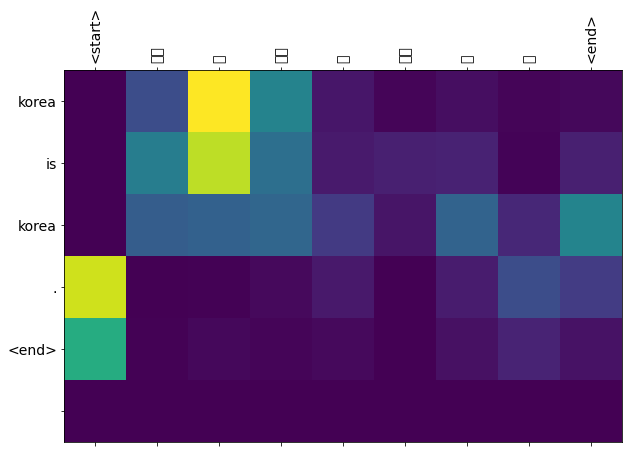

In [138]:
translate('한국은 훌륭한 나라이다')

Input: <start> 한국 의 소중 한 문화 <end>
Predicted translation: the south cultural team to play to be together . <end> 


/tmp/ipykernel_161/4081095973.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_161/4081095973.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54868 missing from curren

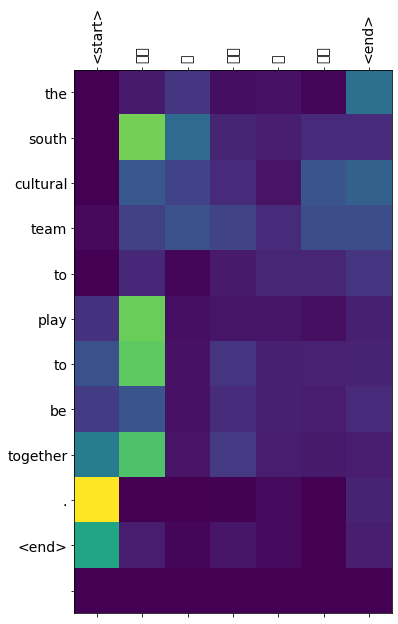

In [140]:
translate("한국의 소중한 문화")

Input: <start> 공부 가 재미있 다 <end>
Predicted translation: these things are good . <end> 


/tmp/ipykernel_161/4081095973.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_161/4081095973.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44277 missing from curren

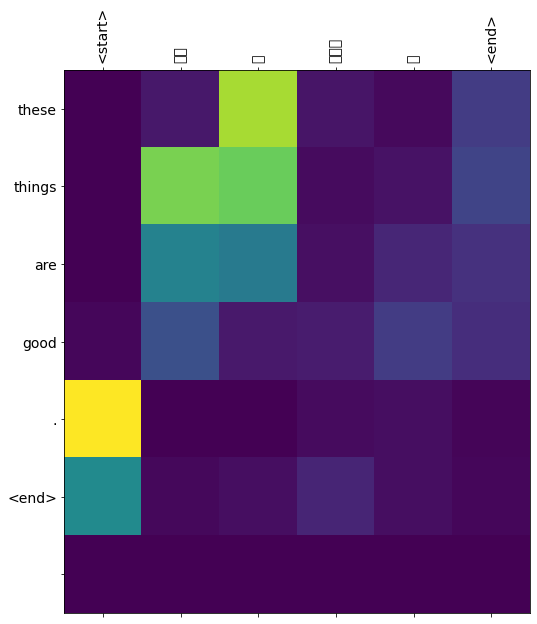

In [149]:
translate("공부가 재미있다")

# 실험종료

기존의 데이터로는 학습이 다소 어려워, 다른 한영 말뭉치를 통해 학습을 추가적으로 진행했으며, 코드는 구글의 예제 코드를 따왔다
하는 과정에서 전처리 과정에 따라 많은 에러를 겪었으며, 코드가 복잡해지다보니 군데군데 에러가 발생하는 구간이 많아 오래 걸리게 되었다
아직까지 커스텀 루프를 통한 모델 학습에는 좀 더 이해도가 필요할 것으로 보인다  
학습이 빨리 이루어지지 않아 성능 확인과 개선에 시간이 오래 걸렸으며, 이를 위해 커스텀 학습 루프에 적응 후 병렬 학습에 대한 적응을 할 필요가 있었다  
좀 더 많은 데이터를 썼으면 하는 아쉬움이 남는다